In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pymannkendall as mk
from sklearn import metrics
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
df_norm = pd.read_csv('data/dynamic_variables_all_normalized.csv', index_col=0, parse_dates=True)
df_norm = df_norm[(df_norm.index >= '1999-10-01') & (df_norm.index <= '2023-09-30')]

In [3]:
# average gw depth across all wells
df_norm['gw_avg'] = df_norm.iloc[:, 2:].mean(axis=1)

### Plot normalized values of average GW depth, Q, and pumping rates

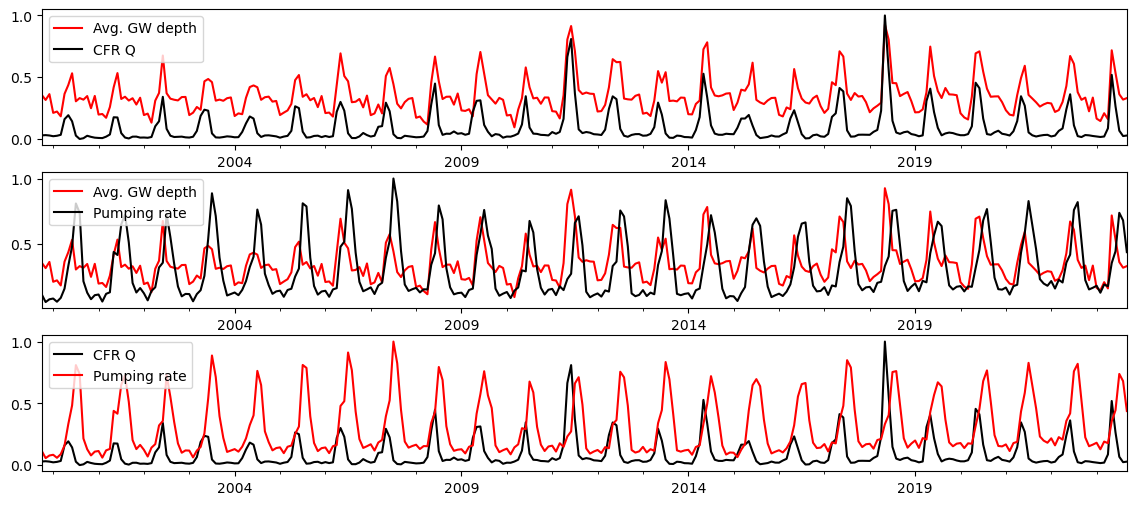

In [4]:
# plot normalized time seris of gw, q, and pumping rate   
fig, ax = plt.subplots(3, 1, figsize=(14, 6))
df_norm['gw_avg'].plot(ax=ax[0], color='red', label='Avg. GW depth')
df_norm['Q'].plot(ax=ax[0], color='black', label='CFR Q')
df_norm['gw_avg'].plot(ax=ax[1], color='red', label='Avg. GW depth')
df_norm['pumping_rate'].plot(ax=ax[1], color='black', label='Pumping rate')
df_norm['Q'].plot(ax=ax[2], color='black', label='CFR Q')
df_norm['pumping_rate'].plot(ax=ax[2], color='red', label='Pumping rate')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

### Model $\Delta$ groundwater with $\Delta$ Q using MLR 

In [5]:
# calculate difference between time steps
df_diff = df_norm.diff().shift().dropna()

# calculate time lagged cfr values
df_cfr = pd.DataFrame(df_diff['Q'])
for i in range(1, 13):
    cname = 'Q_lag_' + str(i)
    df_cfr[cname] = df_diff['Q'].shift(-i)
df_cfr = df_cfr.dropna()
df_cfr.head()

# get just well data
df_wells = df_diff.iloc[:, 2:-1]
df_wells = df_wells.loc[df_cfr.index]

# train test split
x_train, x_test, y_train, y_test = train_test_split(df_cfr, df_wells, test_size=0.2, random_state=42)
mlr = LinearRegression()

### Plot RMSE values for models using additional time lagged Q values as predictors

In [6]:
df_rmse = pd.DataFrame(index=range(1, 13), columns=y_test.columns)
for i in range(y_test.shape[1]):
    rmse_list = []
    for j in range(1, 13):
        mlr.fit(x_train.iloc[:, :j], y_train.iloc[:, i])
        y_pred = mlr.predict(x_test.iloc[:, :j])
        rmse = np.sqrt(metrics.mean_squared_error(y_test.iloc[:, i], y_pred))
        rmse_list.append(rmse)
    df_rmse[y_test.columns[i]] = rmse_list

Text(0.5, 0, 'Time lag (months)')

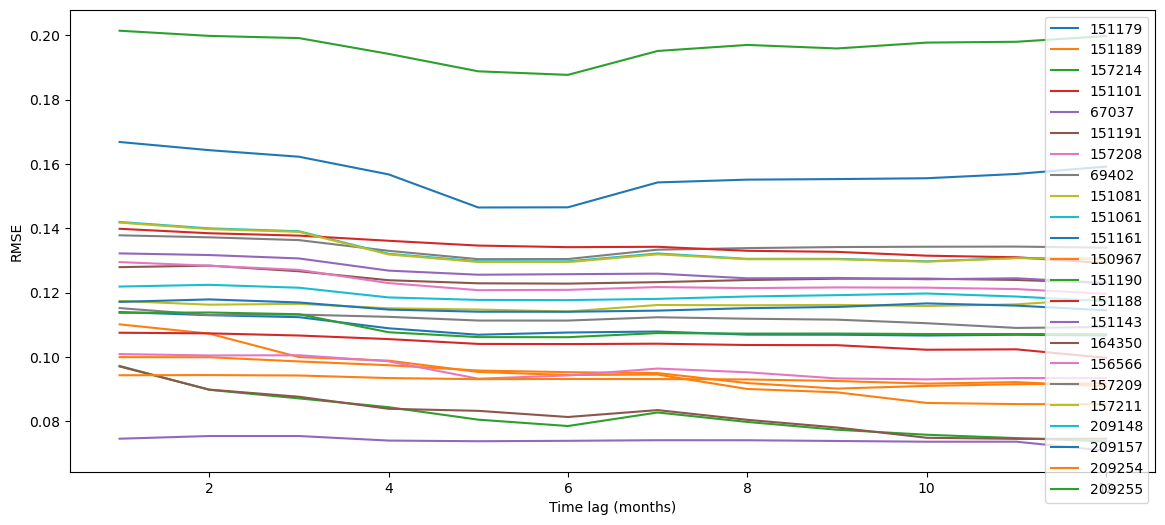

In [7]:
df_rmse.plot(figsize=(14, 6))
plt.ylabel("RMSE")
plt.xlabel("Time lag (months)")

Results suggest that for most wells there is very little advantage to using time-lagged Q values. In addition, from a process perspective, any lagged relationship is likely within the one-month time step, therefore we will only use Q values at time t.  

In [8]:
mlr2 = LinearRegression()
mlr2.fit(df_cfr['Q'].values.reshape(-1, 1), 
         df_wells.iloc[:, 0].values.reshape(-1, 1))
y_pred = mlr2.predict(df_cfr['Q'].values.reshape(-1, 1))
y_pred = pd.Series(y_pred.reshape(-1), index=df_wells.index).shift(-1)
y_corr = df_norm.iloc[:, 2].sub(y_pred.cumsum())

### Plot predicted vs. actual

0.16237042520576705
0.29797000068373647


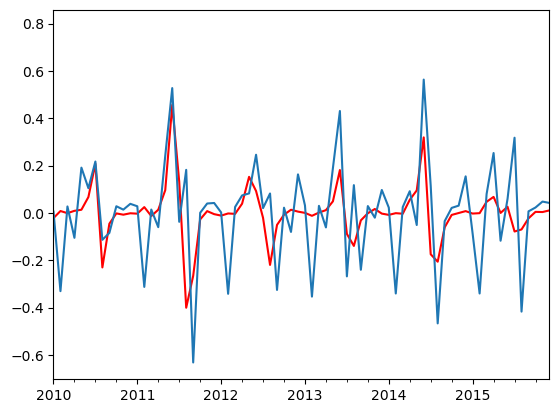

In [9]:
y_pred.shift(1).plot(xlim=('2010-01-01', '2015-12-31'), color='red', label='Predicted GW depth')
df_wells.iloc[:, 0].plot(xlim=('2010-01-01', '2015-12-31'))
print(np.sqrt(metrics.mean_squared_error(df_wells.iloc[1:, 0], y_pred.shift(1).iloc[1:])))
print(metrics.r2_score(df_wells.iloc[1:, 0], y_pred.shift(1).iloc[1:]))

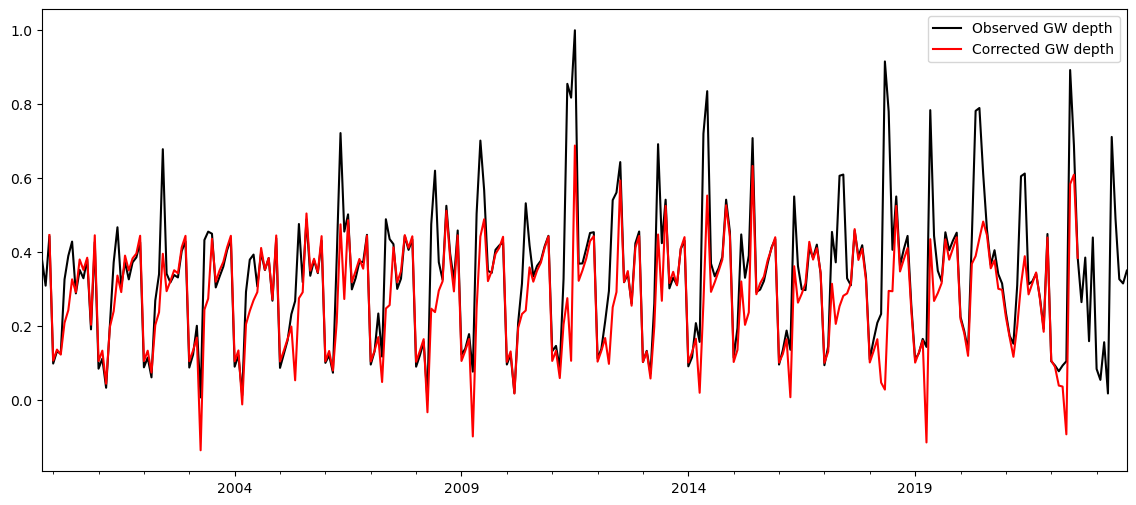

In [10]:
df_norm.iloc[:, 2].plot(figsize=(14, 6), color='black', label='Observed GW depth')
y_corr.dropna().plot(color='red', label='Corrected GW depth')
plt.legend()

This does not seem to be removing full streamflow signal. I will try without normalizing like the original [paper](https://ngwa.onlinelibrary.wiley.com/doi/10.1111/j.1745-6584.2010.00780.x).

In [11]:
df = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv', index_col=0, parse_dates=True)

# Clip data
df = df[(df.index >= '1999-10-01') & (df.index <= '2023-09-30')]

# Multiply depths by -1
depth_cols = [i for i in df.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df[col] *= -1

# Calculate difference between time steps
df_diff2 = df.diff().dropna()
df_q = df_diff2['Q']
df_wells2 = df_diff2.iloc[:, 1:]

In [108]:
df_corr = df.iloc[:, 1:].copy()

for well in range(df_wells2.iloc[:, 1:].shape[1]):
    mlr3 = LinearRegression()
    mlr3.fit(df_q.values.reshape(-1, 1), 
            df_wells2.iloc[:, well].values.reshape(-1, 1))
    y_pred2 = mlr3.predict(df_q.values.reshape(-1, 1))
    y_pred2 = pd.Series(y_pred2.reshape(-1), index=df_wells2.index).shift(-1)
    y_corr2 = df.iloc[:, well+1].sub(1*y_pred2.cumsum())
    df_corr.iloc[:, well] = y_corr2
    

<Axes: xlabel='time'>

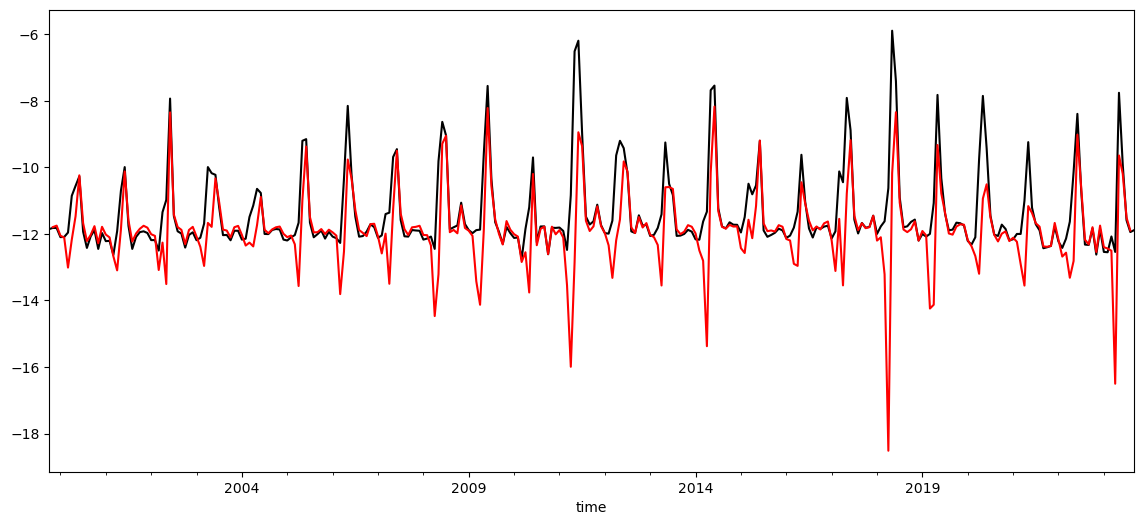

In [109]:
df['209254'].plot(figsize=(14, 6), color='black', label='Observed GW depth')
df_corr['209254'].plot(figsize=(14, 6), color='red', label='Corrected GW depth')

We still do not seem like we are removing the signal. But there does seem to be some interesting patterns. There are consistent big corrections in spring where corrected gw depths are much lower than observed, and there are some smaller, but still significant corrections at peak gw levels (min. depth). Let's see what the trends look like for the corrected depths.  

In [110]:
df_melt = df_corr.dropna().reset_index().melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [111]:
# Calculate trends and p-values and add to the DataFrame
def get_trend(x):
    """Define a function to fit a linear regression model and return the slope, 
    intercept, and p-value."""
    model = smf.ols('value ~ timestamp', data=x).fit()
    return pd.Series([model.params['Intercept'], 
                      model.params['timestamp'], 
                      model.pvalues['timestamp']], 
                     index=['intercept', 'slope', 'p-value'])

def get_mk_trend(x):
    """Define a function to calculate the Mann-Kendall trend and return the trend 
    and p-value."""
    mk_res = mk.seasonal_test(x.value, period=12)
    return pd.Series([mk_res.intercept, mk_res.slope, mk_res.p],
                     index=['intercept', 'slope', 'p-value'])

In [112]:
# Melt dataframe
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

In [113]:
# Define a function to plot the data and the trendline
def plot_data_and_trendline(data, color, mann_kendall=True):
    """Switch mann_kendall to False if using linear regression"""
    
    x = data['timestamp']
    y = data['value']
    slope = data['slope'].iloc[0]
    intercept = data['intercept'].iloc[0]
    p_value = data['p-value'].iloc[0]
    
    # Convert the 'time' column to datetime for plotting
    x_range = np.arange(len(x))/12
    x_datetime = pd.to_datetime(x, unit='s')
    
    # Plot the data
    plt.plot(x_datetime, y, color='gray', linewidth=0.75)
    
    # Set the color of the trendline based on the p-value
    trend_color = 'red' if p_value < 0.1 else 'black'

    # Add the p-value to the plot
    plt.text(0.3, 0.1, f'p-value: {p_value:.2e}', ha='left', va='top', transform=plt.gca().transAxes)

    # Plot the trendline
    if mann_kendall:
        plt.plot(x_datetime, intercept + slope * x_range, color=trend_color)
    else:
        plt.plot(x_datetime, intercept + slope * x, color=trend_color)

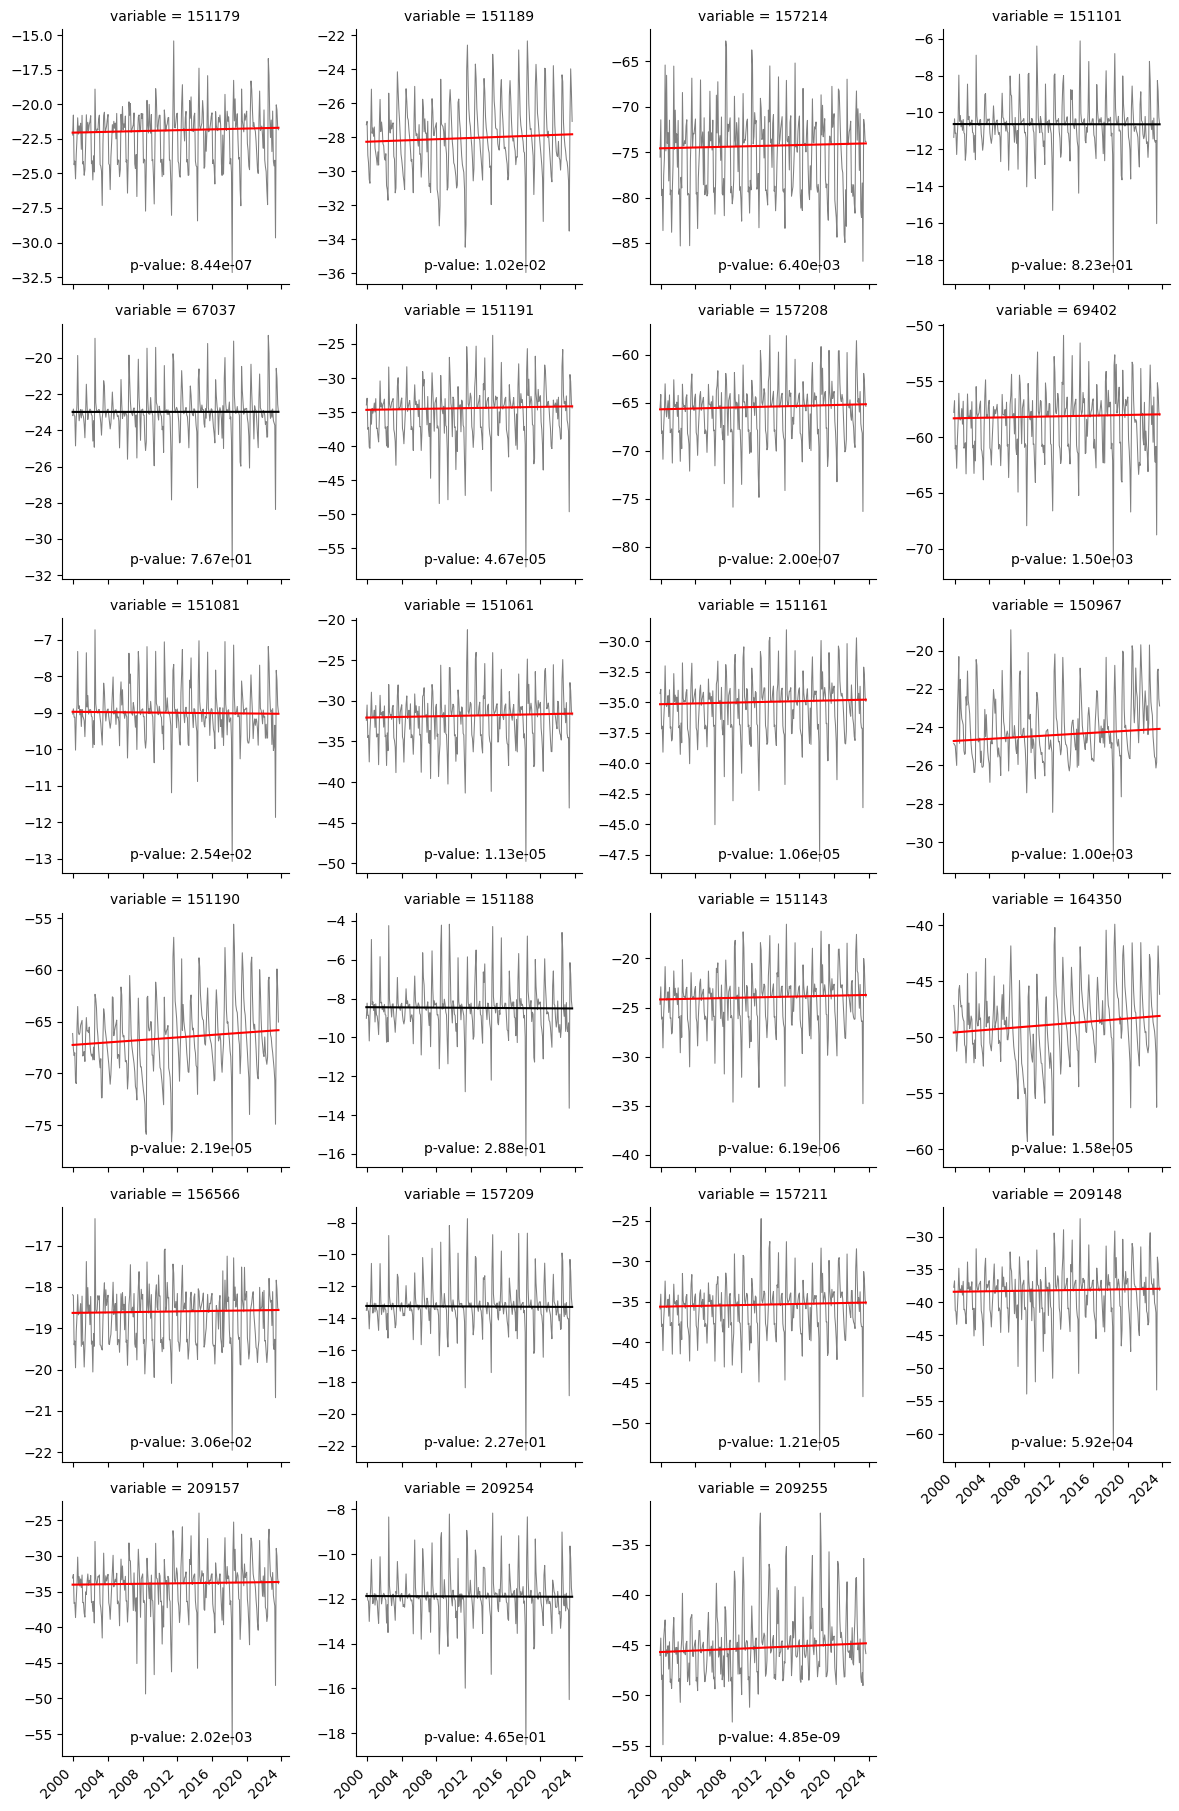

In [114]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

I am surprised, the correction did not take out many of the trends--with exception to '209254'. Something is off. I will try a different stats library just to make sure there is not a mistake in the code. 

In [25]:
import statsmodels.api as sm

In [116]:
df_corr2 = df.iloc[:, 1:].copy()
for well in range(df_wells2.iloc[:, 1:].shape[1]):

    x = df_q.values
    X = sm.add_constant(x)
    y = df_wells2.iloc[:, well].values
    model = sm.OLS(y, X).fit()
    y_pred_sm = model.predict(X)
    y_pred_sm = pd.Series(y_pred_sm, index=df_wells2.index)
    y_corr_sm = df.iloc[:, well+1].sub(y_pred_sm.cumsum())
    df_corr2.iloc[:, well] = y_corr_sm

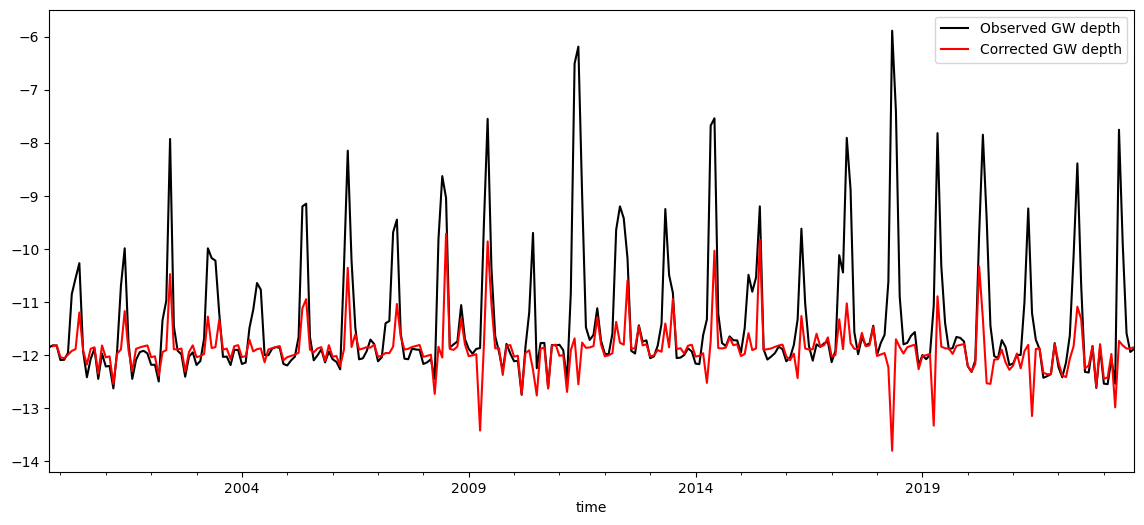

In [117]:
df['209254'].plot(figsize=(14, 6), color='black', label='Observed GW depth')
df_corr2['209254'].plot(figsize=(14, 6), color='red', label='Corrected GW depth')
plt.legend()

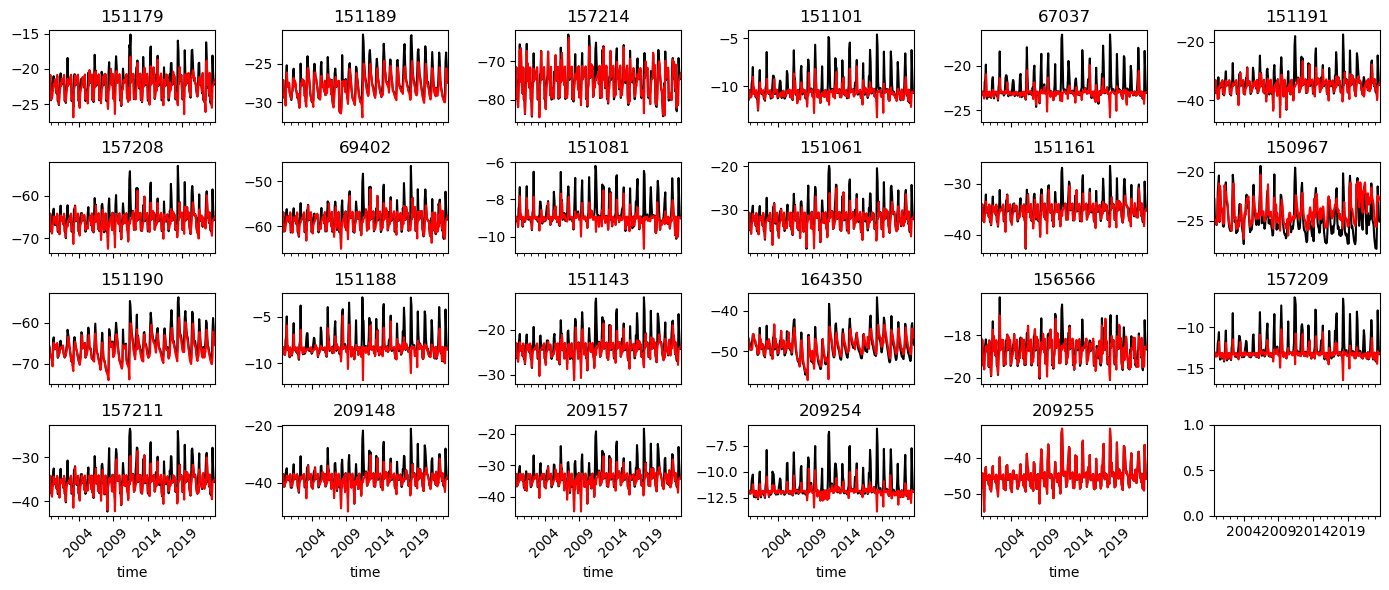

In [123]:
fig, ax = plt.subplots(4, 6, figsize=(14, 6), sharex=True)
for i in range(df_wells2.shape[1]):
    df.iloc[:, i+1].plot(ax=ax[i//6, i%6], color='black', label='Observed GW depth')
    df_corr2.iloc[:, i].plot(ax=ax[i//6, i%6], color='red', label='Corrected GW depth')
    ax[i//6, i%6].tick_params(axis='x', rotation=45)
    ax[i//6, i%6].title.set_text(df.columns[i+1])
    
plt.tight_layout()
plt.show()

In [124]:
# df_corr2 = df_corr2[(df_corr2.index >= '2014-10-01') & (df_corr2.index <= '2023-09-30')]

In [125]:
df_melt2 = df_corr2.dropna().reset_index().melt(id_vars='time')
df_melt2['time'] = pd.to_datetime(df_melt2['time'])

In [126]:
# Melt dataframe
df_trend = df_melt2.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

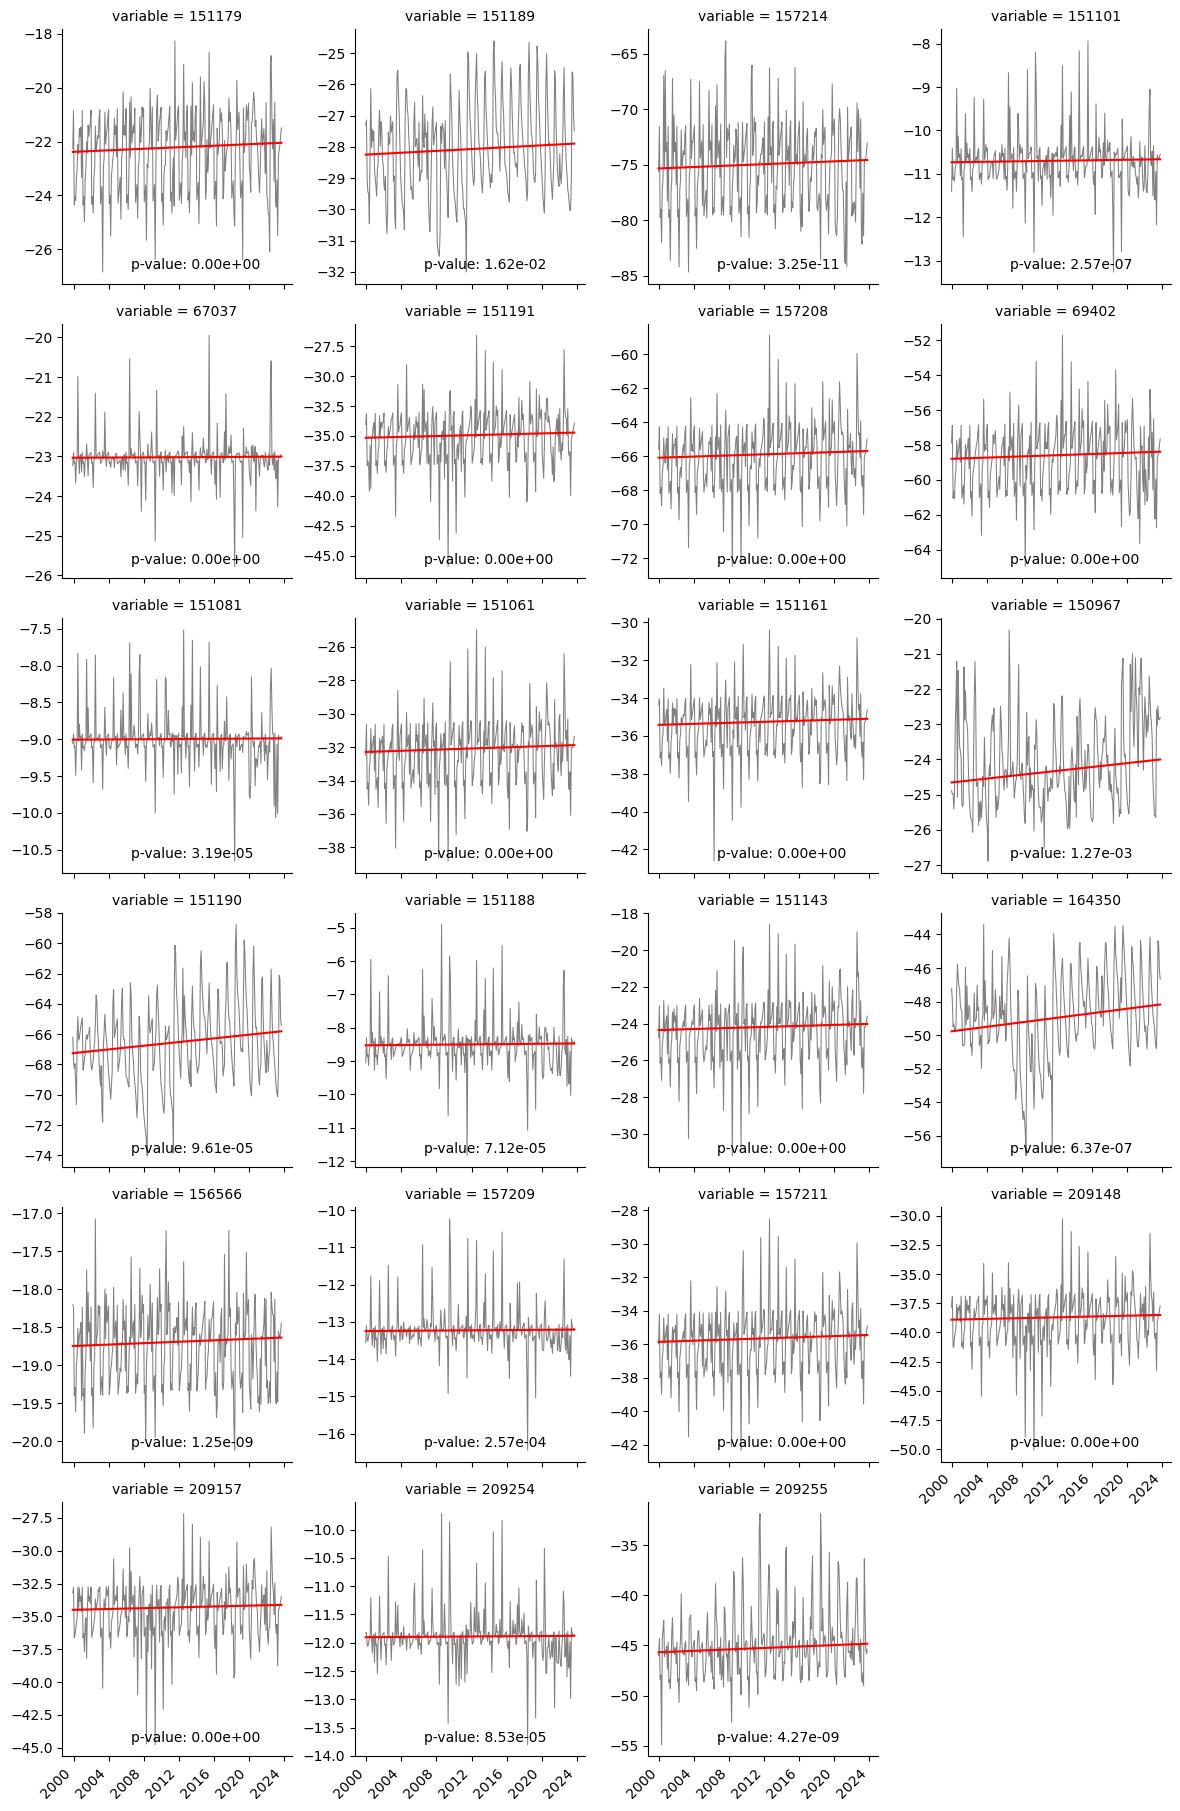

In [127]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()